# HW 2

Deep Learning, Spring 2022

Use neural networks to the fit one year's worth of solar wind measurements.

In [1]:
# Import dependencies
from time import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch modules
import torch
from torch import nn
import torch.utils.data as Data

# Set plot parameters for entire notebook
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 80

# Check GPU availability - may not be needed since relatively small models
torch.cuda.is_available()

False

# 1 Data preprocessing

The CSV file should be in the same directory as this notebook. Otherwise, update the file_name path.

References:
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

## 1.1 Read CSV and define variable categories

The CSV file is stored in a public GitHub repository for convenience. Alternatively, reference a local file or upload the file into Colab's runtime.

In [ ]:
url = 'https://raw.githubusercontent.com/vtd9/multilayer-perceptron/' + \
  'temp_space/Sample_Data_Set.csv'
df = pd.read_csv(url)

In [ ]:
# Independent variables
indep_vars = ['Bx', 'By', 'Bz', 'Bmag_avg', 'Ni_avg', 'Vx', 'Vy', 'Vz', 'VSW', 
              'Vth_mag_Ion', 'Vth_para_Ion', 'Vth_perp_Ion', 'Ne', 'Ue', 
              'Te', 'Ti', 'Ti_para', 'Ti_perp']

# Derived variables: from independent variables using formulas
deriv_vars = ['VA', 'Beta', 'Beta_para', 'Beta_perp', 
              'Omega_i', 'omega_pi', 'omega_pe', 'rho_i', 'rho_s', 'rho_c', 
              'd_i', 'd_e', 'sigma_i', 'Lperp', 'lambda_d']

# Dependent variable: target
dep_var = ['k_brk']

# Check that the number of variables in each category are as expected
print('Independent: {}, derived: {}, dependent: {}'.format(
    len(indep_vars), len(deriv_vars), len(dep_var)))

# Convert Pandas dataframes to PyTorch tensors by column names
indep = torch.tensor(df[indep_vars].values)
deriv = torch.tensor(df[deriv_vars].values)
dep = torch.tensor(df[dep_var].values)

Independent: 18, derived: 15, dependent: 1


## 1.2 Prepare for feeding into network

In [ ]:
# Normalize inputs and create datasets
indep_set = Data.TensorDataset(torch.nn.functional.normalize(indep, dim=0), dep)
deriv_set = Data.TensorDataset(torch.nn.functional.normalize(deriv, dim=0), dep)

# Decide on training, validation, and testing splits
train_size = int(0.8 * len(df))
valid_size = int(0.1 * len(df))
test_size = len(df) - (train_size + valid_size)
splits = [train_size, valid_size, test_size]

print('Training, validation, & testing split:', splits)

# Split the data for both indep-dep pairs & derived-dep pairs
train_indep, valid_indep, test_indep = Data.random_split(indep_set, splits)
train_deriv, valid_deriv, test_deriv = Data.random_split(deriv_set, splits)

# Define dataloaders
batch_size = 64
n_work = 2
train_loader_indep = Data.DataLoader(dataset=train_indep, batch_size=batch_size, 
                                     shuffle=True, num_workers=n_work)
valid_loader_indep = Data.DataLoader(dataset=valid_indep, batch_size=batch_size,
                                     shuffle=True, num_workers=n_work)
test_loader_indep = Data.DataLoader(dataset=test_indep, batch_size=batch_size, 
                                    shuffle=True, num_workers=n_work)
train_loader_deriv= Data.DataLoader(dataset=train_deriv, batch_size=batch_size, 
                                    shuffle=True, num_workers=n_work)
valid_loader_deriv = Data.DataLoader(dataset=valid_deriv, batch_size=batch_size, 
                                     shuffle=True, num_workers=n_work)
test_loader_deriv = Data.DataLoader(dataset=test_deriv, batch_size=batch_size, 
                                    shuffle=True, num_workers=n_work)

Training, validation, & testing split: [5626, 703, 704]


In [ ]:
# Check dimensions
indep_set[:][0].shape, deriv_set[:][0].shape

(torch.Size([7033, 18]), torch.Size([7033, 15]))

## 1.3 Visualize the input data

In [ ]:
def plot_many(xs, y, xs_names, num_cols=6, title='', subfont=10,
              size=(10, 8)):
  '''
  Plot multiple variables against a single one.
  '''
  num_plots = len(xs_names)
  num_rows = int(num_plots / num_cols) + 1
  plt.subplots(figsize=size)

  # For each variable in x
  for i in range(num_plots):
      plt.subplot(num_rows, num_cols, i + 1)
      plt.plot(xs[:, i].cpu(), y.cpu(), '.', alpha=0.5)
      plt.title(xs_names[i], y=1.15, fontsize=subfont)
      plt.ticklabel_format(style='sci', scilimits=(-3, 4), axis='x')
  plt.suptitle(title)
  plt.tight_layout(rect=[0, 0.05, 1, 0.96])

In [ ]:
#plot_many(indep, dep[:, 0], indep_vars, title='Independent variables vs. $k_{brk}$')

In [ ]:
#plot_many(deriv, dep[:, 0], deriv_vars, title='Derived variables vs. $k_{brk}$')

# 2 Define classes and functions

References:
* https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

## 2.1 `Net` class

Define a general template to easily create models.

Regarding the order of activation, batch normalization, and dropout, and whether dropout is necessary when the model has batch normalization, different people seem to have different opinions: 
* https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout. 
* https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization/tutorial

Here, apply batch normalization after activation and dropout after normalization.

In [38]:
class Net(nn.Module): 
  def __init__(self, n_in, hiddens, n_out, batch_norm=True, p_dropout=0.5):
    super(Net, self).__init__()
    self.n_in = n_in
    self.n_out = n_out
    layers = []
    
    # Define hidden layer(s)
    hiddens_list = [n_in, ] + list(hiddens)
    for i, hidden in enumerate(hiddens_list[:-1]):
        curr_hidden = [nn.Linear(hidden, hiddens_list[i+1]),]

        # Add activation (ReLU)
        curr_hidden.append(nn.ReLU())

        # If set, add batch normalization
        if batch_norm:
            curr_hidden.append(nn.BatchNorm1d(hiddens_list[i+1]))

        # If set, add dropout
        if p_dropout is not None:
            curr_hidden.append(nn.Dropout(p_dropout))    
            
        layers += curr_hidden 

    # Define output layer
    layers.append(nn.Linear(hiddens[-1], n_out))

    # Define entire stack
    self.stack = nn.Sequential(*layers)
      
  def forward(self, x):
      logits = self.stack(x)
      return logits

# Initialize parameters
def init_parameters(m):
  if isinstance(m, nn.Linear):
      # weights: Kaiming initialization
      nn.init.kaiming_normal_(m.weight)

      # biases: set to 0, as discussed in class
      m.bias.data.fill_(0.0) # Set bias to 0

In [39]:
def mult_models(n_in, hidden_dims, n_out, lr, momentum=0.5,
                decay=1e-5, opt_sgd=True):
  '''
  Create multiple models using one or more configurations for the hidden 
  layers. Return as a dictionary with keys based on the number of neurons in
  the hidden layers as well the model-specific add-ons or lack thereof.
  '''
  models_dict = {}
  for dim in hidden_dims:  
    # Batch norm & dropout of 50%
    model = Net(n_in, dim, n_out)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' drop 50%'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' drop 50%'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), 
                                  lr=lr, weight_decay=decay)}

    # Batch norm & dropout of 25%
    model = Net(n_in, dim, n_out, p_dropout=0.25)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' drop 25%'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' drop 25%'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), 
                                  lr=lr, weight_decay=decay)}

    # Batch norm, but no dropout
    model = Net(n_in, dim, n_out, p_dropout=None)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' no drop'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' no drop'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), lr=lr)}
    
    # No norm, no dropout
    model = Net(n_in, dim, n_out, batch_norm=False, p_dropout=None)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' no norm'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' no norm'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), lr=lr)}

  return models_dict

## 2.2 Functions for training, testing, and plotting

Train & test functions for one loop through the datasets (aka one epoch) as well as loop over multiple epochs.

Option to configure a GPU with PyTorch. References: 

* https://pytorch.org/docs/stable/notes/cuda.html
* https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [ ]:
def train_loop(loader, model, loss_fun, optimizer, device='cpu'):
  '''
  Train a model for one epoch - i.e., one pass through the training data set.
  Since gradients must be calculated anyways during training, store gradient
  of prediction wrt to inputs and return the average over the batches.
  '''
  train_loss = 0.0
  model = model.double()
  model = model.to(device)
  input_grads = torch.zeros(model.n_in, requires_grad=False)

  # For each batch
  for X, y in loader:
    X.requires_grad = True
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad() # clear previous gradients
    yhat = model(X) # prediction
    loss = loss_fun(yhat, y) # compute loss
    train_loss += loss.item() # assume reduction over batch

    loss.backward(retain_graph=True) # compute gradients
    with torch.no_grad():
      dyhat_dX, = torch.autograd.grad(yhat, X, torch.ones(yhat.shape))
      dyhat_dX_batch = dyhat_dX.mean(dim=0) # mean over batch
      input_grads += dyhat_dX_batch
    optimizer.step() # apply gradients

  # Average over number of batches
  return train_loss/len(loader), input_grads/len(loader)
    
def test_loop(loader, model, loss_fun, device='cpu', return_y=False):
  '''
  Test a model through one pass through a validation/test data set.
  '''
  test_loss = 0.0
  model = model.double()
  model = model.to(device)

  # No backprop during validation/testing
  with torch.no_grad():
    for X, y in loader:
      X = X.to(device)
      y = y.to(device)
      yhat = model(X)
      test_loss += loss_fun(yhat, y).item()

  # If requested, return last yhat & the corresponding labels, too
  if return_y: 
    return yhat, y, test_loss/len(loader)
  else: # Else, return average loss in the loop
    return test_loss/len(loader)

def train_epochs(train_loader, valid_loader, model, loss_fun, optimizer, 
    epochs, verbose=False, use_gpu=False):
    '''
    Train and validate a model over multiple epochs.
    '''
    train_losses = torch.empty(epochs)
    valid_losses = torch.empty(epochs)
    grads = torch.empty(epochs, model.n_in)

    if use_gpu:
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
      device = 'cpu'

    # For each epoch
    for epoch in range(epochs):
        train_losses[epoch], grads[epoch] = train_loop(train_loader, model, 
            loss_fun, optimizer=optimizer, device=device)
        valid_losses[epoch] = test_loop(valid_loader, model, 
                                       loss_fun, device=device)
    
        if verbose:
            print('epoch: {}\ttraining loss: {:.3e}'
            '\tvalidation loss: {:.3e}'.format(
                epoch, train_losses[epoch], valid_losses[epoch]))
    
    return train_losses, valid_losses, grads

### 2.2.1 Multiple models

Functions to handle multiple models.

In [ ]:
def train_mult_models(models, train_loader, valid_loader, loss_fun,
                      epochs=25, verbose=False, use_gpu=False):
  '''
  Train (and validate) multiple models in sequence. Assume `models` is a
  dictionary produced by the above function `mult_models`.
  '''
  fun_start = time()
  for key, value in models.items():
    start = time()
    model = value['model']
    opt = value['opt']
    models[key]['result'] = train_epochs(
        train_loader, valid_loader, model, 
        loss_fun=loss_fun, optimizer=opt, epochs=epochs, verbose=verbose,
        use_gpu=use_gpu)
    print('{0: <25}'.format(key), '{:.1f}s'.format(time() - start))
  print('Total time: {:.1f}s'.format(time() - fun_start))

def get_ending_losses(models, get_valid=True):
  '''
  Print out multiple models' performance after the last loop.
  '''
  for key, value in models.items():
    if get_valid:
      print('{0: <25}'.format(key), 
            'validation loss: {:.3e}'.format(value['result'][1][-1]))
    else:
      print('{0: <25}'.format(key), 
            'training loss: {:.3e}'.format(value['result'][0][-1]))

def plot_mult_models(models, xlabel='Epoch', ylabel='Mean squared error', 
                     yscale='log', title='', train_index=0, valid_index=1,
                     result_key='result', train_append=' training', 
                     valid_append=' validation', train_style='-', 
                     valid_style='--', bottom_legend=True):
  '''
  Plot multiple models on the same graph, each with its own training and 
  validation results.
  '''
  colors=itertools.cycle(('tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                          'tab:purple', 'tab:pink','b', 'y', 'c', 'm', 'k',
                          'tab:gray', 'tab:olive'))
  for key, value in models.items():
    color = next(colors)
    epochs = value[result_key][0].shape[0]
    # Plot training performance
    plt.plot(np.arange(epochs), 
        value[result_key][train_index], train_style, 
        color=color, label=key+train_append)
    
    # Plot validation performance
    plt.plot(np.arange(epochs), 
        value[result_key][valid_index], valid_style, 
        color=color, label=key+valid_append)
  plt.title(title)
  plt.yscale(yscale)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if bottom_legend:
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.1))
  else:
     plt.legend(ncol=2)

# 3 Independent &rarr; dependent variables

Create a model to relate the independent variables to the dependent variable.

In [ ]:
# Standard mean squared error loss function
mse = nn.MSELoss(reduction='mean') # default reduction

## 3.1 Three hidden layers

In [ ]:
# Create container to store models, optimizers, & results in
m3 = mult_models(len(indep_vars), [(16, 8, 4), (8, 4, 2)], 1, lr=0.01)

# Train
train_mult_models(m3, train_loader_indep, valid_loader_indep, mse, 25)

(16, 8, 4) drop 50%       10.8s
(16, 8, 4) drop 25%       10.7s
(16, 8, 4) no drop        10.2s
(16, 8, 4) no norm        9.2s
(8, 4, 2) drop 50%        10.6s
(8, 4, 2) drop 25%        12.2s
(8, 4, 2) no drop         10.4s
(8, 4, 2) no norm         9.4s
Total time: 83.4s


In [ ]:
# See actual losses from validation
get_ending_losses(m3)

(16, 8, 4) drop 50%       validation loss: 9.903e-12
(16, 8, 4) drop 25%       validation loss: 1.043e-07
(16, 8, 4) no drop        validation loss: 2.688e-04
(16, 8, 4) no norm        validation loss: 4.367e-06
(8, 4, 2) drop 50%        validation loss: 9.824e-12
(8, 4, 2) drop 25%        validation loss: 9.764e-12
(8, 4, 2) no drop         validation loss: 8.975e-12
(8, 4, 2) no norm         validation loss: 7.359e-08


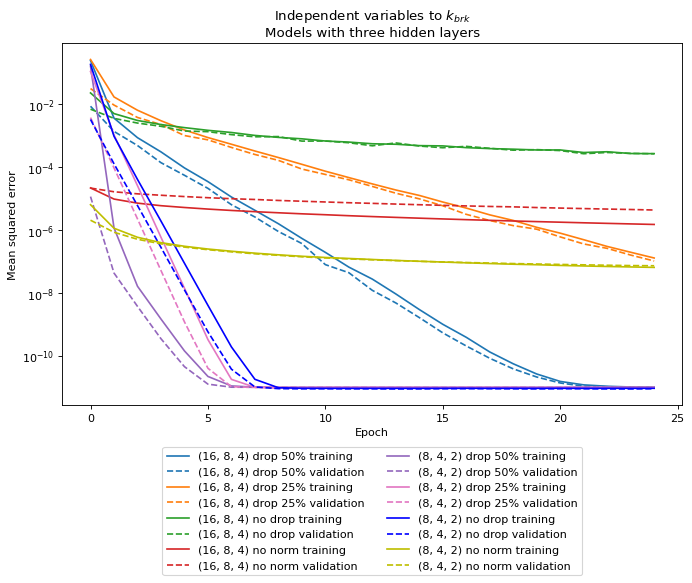

In [ ]:
# Plot on log scale
plot_mult_models(m3, title='Independent variables to $k_{brk}$' 
                 + '\nModels with three hidden layers')

(8e-12, 1.4e-11)

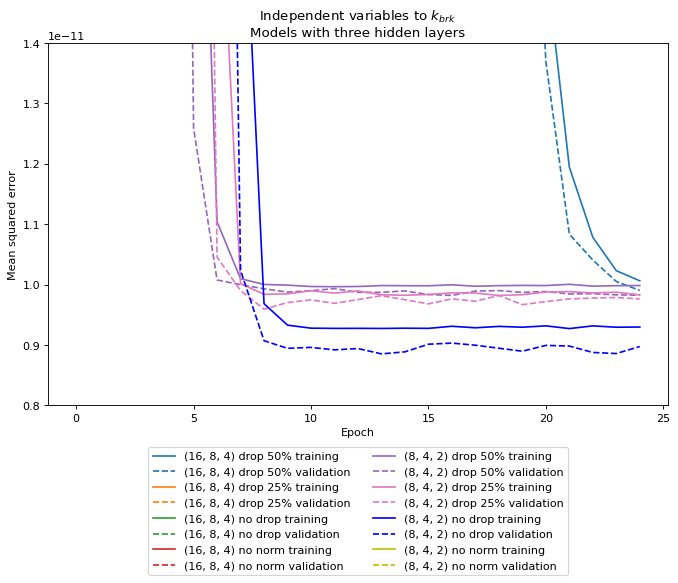

In [ ]:
# Zoom in and plot on linear scale
plot_mult_models(m3, yscale='linear', title='Independent variables to $k_{brk}$'
                 + '\nModels with three hidden layers')
plt.ylim(8e-12, 1.4e-11)

#### 3.1.1 ADAM

Experiment with another optimization algorithm, ADAM, instead of stochastic gradient descent (SGD).

In [ ]:
m3a = mult_models(len(indep_vars), [(16, 8, 4), (8, 4, 2)], 1, 0.01, opt_sgd=False)
train_mult_models(m3a, train_loader_indep, valid_loader_indep, mse, epochs=25)

(16, 8, 4) drop 50%       17.2s
(16, 8, 4) drop 25%       17.4s
(16, 8, 4) no drop        18.5s
(16, 8, 4) no norm        22.7s
(8, 4, 2) drop 50%        17.6s
(8, 4, 2) drop 25%        27.1s
(8, 4, 2) no drop         19.4s
(8, 4, 2) no norm         20.4s
Total time: 160.3s


In [ ]:
get_ending_losses(m3), print('\nCompare to:'), get_ending_losses(m3a)

(16, 8, 4) drop 50%       validation loss: 8.739e-12
(16, 8, 4) drop 25%       validation loss: 8.514e-12
(16, 8, 4) no drop        validation loss: 5.851e-08
(16, 8, 4) no norm        validation loss: 1.033e-06
(8, 4, 2) drop 50%        validation loss: 8.646e-12
(8, 4, 2) drop 25%        validation loss: 8.578e-12
(8, 4, 2) no drop         validation loss: 8.524e-12
(8, 4, 2) no norm         validation loss: 3.310e-08

Compare to:
(16, 8, 4) drop 50%       validation loss: 9.163e-12
(16, 8, 4) drop 25%       validation loss: 8.865e-12
(16, 8, 4) no drop        validation loss: 1.333e-04
(16, 8, 4) no norm        validation loss: 2.944e-07
(8, 4, 2) drop 50%        validation loss: 9.141e-12
(8, 4, 2) drop 25%        validation loss: 9.215e-12
(8, 4, 2) no drop         validation loss: 2.363e-05
(8, 4, 2) no norm         validation loss: 2.972e-10


(None, None, None)

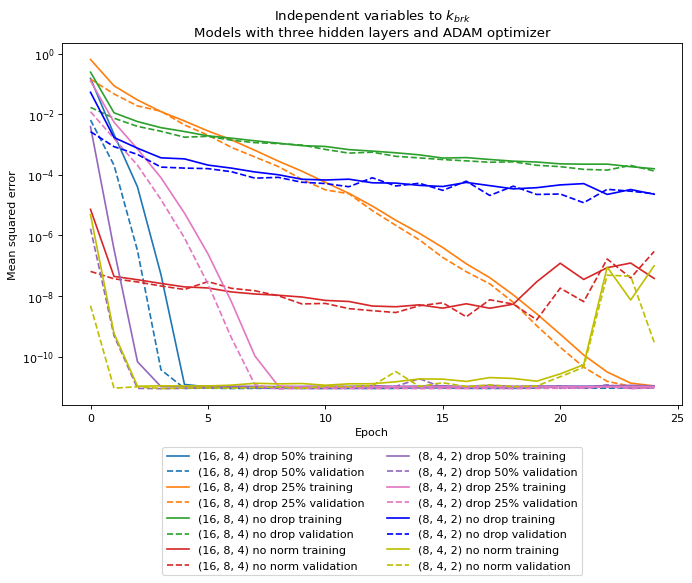

In [ ]:
plot_mult_models(m3a, 
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with three hidden layers and ADAM optimizer')

## 3.2 Four hidden layers

In [ ]:
m4 = mult_models(len(indep_vars), [(24, 16, 8, 4), (12, 8, 4, 2)], 1, 0.01)
train_mult_models(m4, train_loader_indep, valid_loader_indep, mse, 
                  epochs=25)

(24, 16, 8, 4) drop 50%   19.7s
(24, 16, 8, 4) drop 25%   17.9s
(24, 16, 8, 4) no drop    17.4s
(24, 16, 8, 4) no norm    16.2s
(12, 8, 4, 2) drop 50%    18.2s
(12, 8, 4, 2) drop 25%    18.3s
(12, 8, 4, 2) no drop     17.6s
(12, 8, 4, 2) no norm     16.5s
Total time: 141.9s


In [ ]:
get_ending_losses(m4)

(24, 16, 8, 4) drop 50%   validation loss: 8.664e-12
(24, 16, 8, 4) drop 25%   validation loss: 8.623e-12
(24, 16, 8, 4) no drop    validation loss: 1.479e-03
(24, 16, 8, 4) no norm    validation loss: 2.661e-08
(12, 8, 4, 2) drop 50%    validation loss: 8.747e-12
(12, 8, 4, 2) drop 25%    validation loss: 8.612e-12
(12, 8, 4, 2) no drop     validation loss: 9.184e-12
(12, 8, 4, 2) no norm     validation loss: 1.357e-08


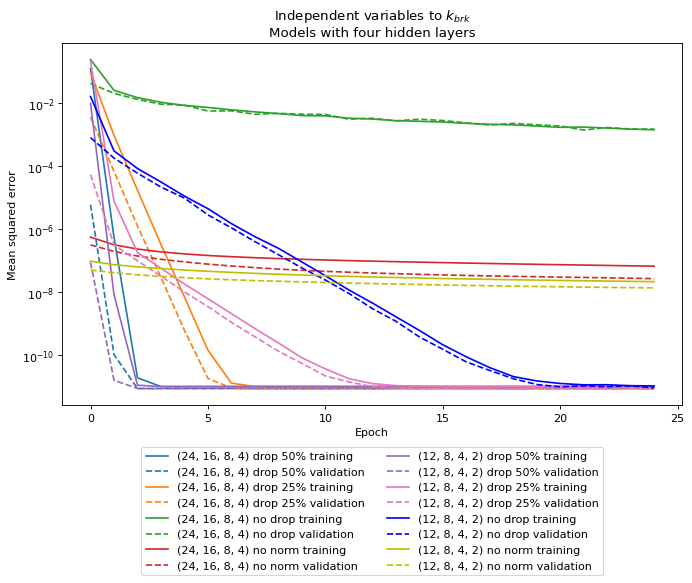

In [ ]:
plot_mult_models(m4,
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with four hidden layers')

(8e-12, 1.3e-11)

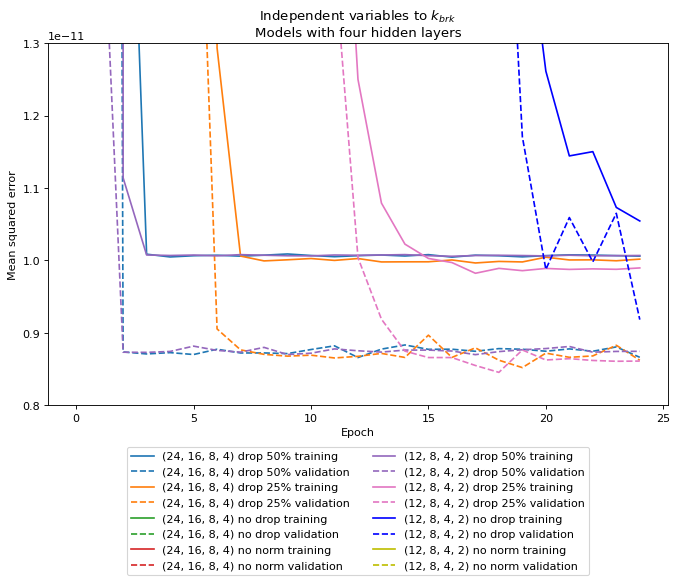

In [ ]:
plot_mult_models(m4, yscale='linear',
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with four hidden layers')
plt.ylim(8e-12, 1.3e-11)

## 3.3 Five hidden layers

In [ ]:
# Create container to store models, optimizers, & results in
m5 = mult_models(len(indep_vars), [(24, 20, 16, 8, 4), (16, 12, 8, 4, 2)], 
                      1, 0.01)

# Train
train_mult_models(m5, train_loader_indep, valid_loader_indep, mse, 
                  epochs=25)

(24, 20, 16, 8, 4) drop 50% 19.5s
(24, 20, 16, 8, 4) drop 25% 19.8s
(24, 20, 16, 8, 4) no drop 21.7s
(24, 20, 16, 8, 4) no norm 24.3s
(16, 12, 8, 4, 2) drop 50% 20.9s
(16, 12, 8, 4, 2) drop 25% 19.6s
(16, 12, 8, 4, 2) no drop 18.9s
(16, 12, 8, 4, 2) no norm 17.2s
Total time: 161.9s


In [ ]:
# See actual losses from validation
get_ending_losses(m5)

(24, 20, 16, 8, 4) drop 50% validation loss: 8.783e-12
(24, 20, 16, 8, 4) drop 25% validation loss: 3.523e-11
(24, 20, 16, 8, 4) no drop validation loss: 8.596e-07
(24, 20, 16, 8, 4) no norm validation loss: 1.413e-06
(16, 12, 8, 4, 2) drop 50% validation loss: 8.719e-12
(16, 12, 8, 4, 2) drop 25% validation loss: 8.719e-12
(16, 12, 8, 4, 2) no drop validation loss: 8.385e-12
(16, 12, 8, 4, 2) no norm validation loss: 1.529e-09


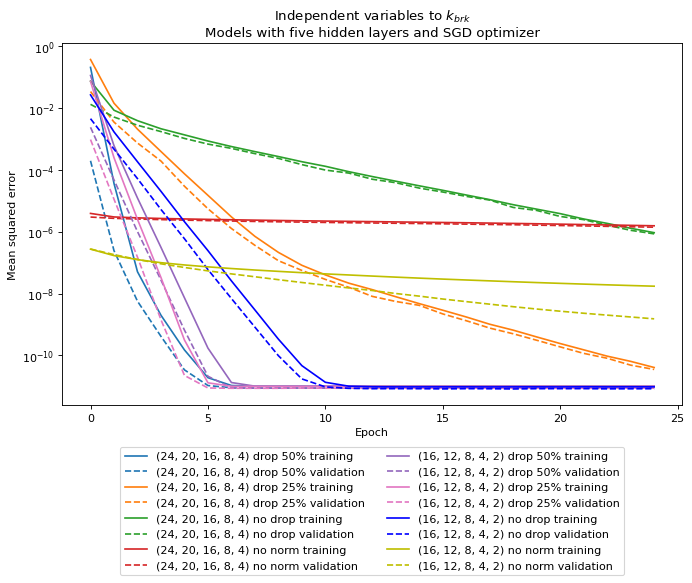

In [ ]:
plot_mult_models(m5,
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with five hidden layers and SGD optimizer')

(7e-12, 1.1e-11)

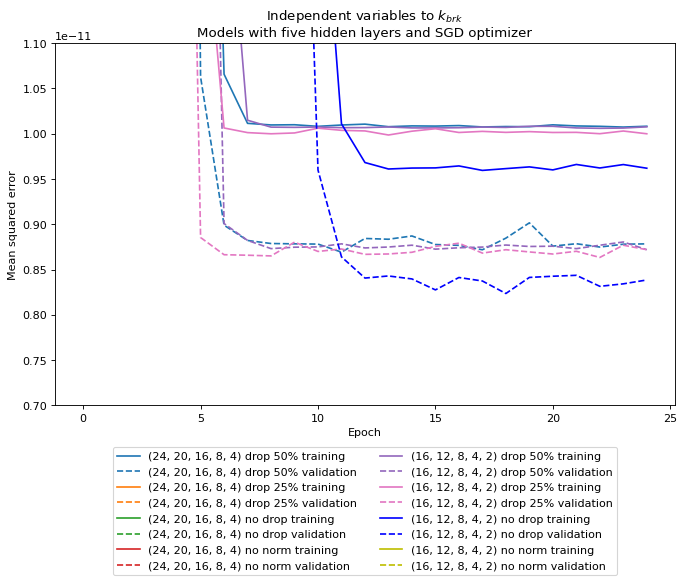

In [ ]:
plot_mult_models(m5, yscale='linear',
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with five hidden layers and SGD optimizer')
plt.ylim(7e-12, 1.1e-11)

## 3.4 Test dataset

Report chosen model's performance with test set

In [ ]:
model = m3['(8, 4, 2) no drop']['model']
test_loss = test_loop(test_loader_indep, model, mse)
print('{:.3e}'.format(test_loss))

8.285e-12


# 4 Derived &rarr; dependent variables

## 3.1 Three hidden layers

In [ ]:
m3_deriv = mult_models(len(deriv_vars), [(16, 8, 4), (8, 4, 2)], 1, lr=0.01)
train_mult_models(m3_deriv, train_loader_deriv, valid_loader_deriv, mse, 25)

(16, 8, 4) drop 50%       13.6s
(16, 8, 4) drop 25%       13.1s
(16, 8, 4) no drop        12.5s
(16, 8, 4) no norm        11.6s
(8, 4, 2) drop 50%        13.4s
(8, 4, 2) drop 25%        13.7s
(8, 4, 2) no drop         13.1s
(8, 4, 2) no norm         12.0s
Total time: 102.8s


In [ ]:
# See actual losses from validation
get_ending_losses(m3_deriv)

(16, 8, 4) drop 50%       validation loss: 8.733e-12
(16, 8, 4) drop 25%       validation loss: 8.577e-12
(16, 8, 4) no drop        validation loss: 8.249e-04
(16, 8, 4) no norm        validation loss: 1.916e-05
(8, 4, 2) drop 50%        validation loss: 1.620e-05
(8, 4, 2) drop 25%        validation loss: 7.175e-11
(8, 4, 2) no drop         validation loss: 8.841e-12
(8, 4, 2) no norm         validation loss: 1.639e-05


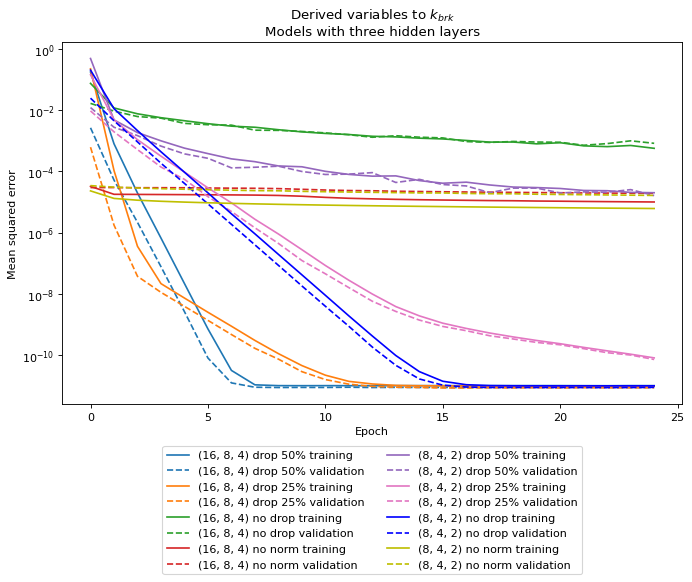

In [ ]:
# Plot on log scale
plot_mult_models(m3_deriv,
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with three hidden layers')

(8e-12, 1.4e-11)

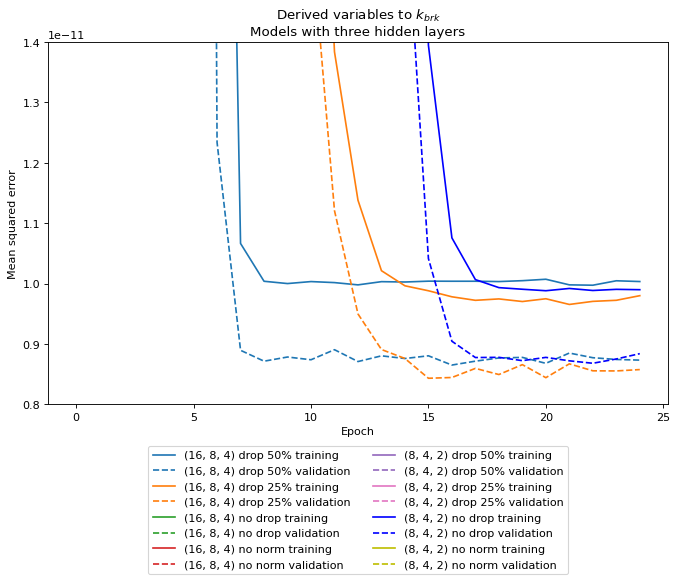

In [ ]:
# Plot on linear scale
plot_mult_models(m3_deriv, yscale='linear',
                 title='Derived variables to $k_{brk}$'
                 + '\nModels with three hidden layers')
plt.ylim(8e-12, 1.4e-11)

# 5 Derivatives

## 5.1 Analytical differentiation

As described in the attached report, the derivatives of the independent and derived variables related to `k_brk` were found by hand. These are defined below for later comparison with the gradients from the neural network.

In [ ]:
def dk_brk_dlambda_r(lambda_r, A=1):
  '''Derivative of k_brk wrt lambda_r'''
  return -A * lambda_r**-2

def dlamda_r_dLperp(Lperp, d_e, rho_s, C0=1):
  '''Derivative of lambda_r wrt Lperp'''
  return (1./9.) * C0 * Lperp**(-8./9.)*(d_e*rho_s)**(4./5.)

def dlambda_r_dd_e(Lperp, d_e, rho_s, C0=1):
  '''Derivative of lambda_r wrt d_e '''
  return C0 * Lperp**(1./9.) * (4./5.) * (d_e*rho_s)**(-1./5.) * rho_s

def dlambda_r_rho_s(Lperp, d_e, rho_s, C0=1):
  '''Derivative of lambda_r wrt rho_s'''
  return C0 * Lperp**(1./9.) * (4./5.) * (d_e*rho_s)**(-1./5.) * d_e

def dLperp_dvsw():
  '''Derivative of Lperp wrt VSW'''
  return 1./(2 * torch.pi * 10**-4)

def dde_domega_pe(omega_pe, c=2.9979E8):
  '''Derivative of '''
  return -c * omega_pe**-2

def drho_s_drho_i(Te, Ti, Z=1.0):
  '''Derivative of '''
  return (Z*Te / (2*Ti))**0.5

def drho_s_dTi(rho_i, Te, Ti, Z=1.0):
  '''Derivative of '''
  return -0.5 * rho_i * (Z*Te / (2.0*Ti**3))**0.5

def drho_s_dTe(rho_i, Te, Ti, Z=1.0):
  '''Derivative of '''
  return 0.5 * rho_i * (Z / (2.0*Ti*Te))**0.5

def domega_pe_dNe(Ne, e=1.6022E-19, eps0=8.8542E-12, mp=9.1094E-31):
  '''Derivative of omega_pe wrt Ne'''
  return 0.5 * (e / (eps0*mp*Ne))**0.5

def drho_i_Vth_perp_Ion(Omega_i):
  '''Derivative of rho_i wrt Vth_perp_Ion'''
  return 1/Omega_i

def drho_i_dOmega_i(Vth_perp_Ion, Omega_i):
  '''Derivative of rho_i wrt Omega_i'''
  return -Vth_perp_Ion/Omega_i**2

def dOmega_i_dB(e=1.6022E-19, mp=9.1094E-31):
  '''Derivative of Omega_i wrt B'''
  return e/mp

def dB_i_dBx(Bx, By, Bz):
  '''Derivative of B wrt Bx'''
  return Bx * (Bx**2 + By**2 + Bz**2)**(-0.5)

def dB_i_dBy(Bx, By, Bz):
  '''Derivative of B wrt By'''
  return By * (Bx**2 + By**2 + Bz**2)**(-0.5)

def dB_i_dBz(Bx, By, Bz):
  '''Derivative of B wrt Bz'''
  return Bz * (Bx**2 + By**2 + Bz**2)**(-0.5)

In [ ]:
def derive_from_tensors(indep_vars, deriv_vars, indep_tensor, deriv_tensor):
  '''
  Derive k_brk wrt different variables using the formulas & the chain rule.
  '''
  grads = {}

  # step 1: From k_brk to lambda_r (lambda_d in spreadsheet)
  grads['lambda_d'] = dk_brk_dlambda_r(
      deriv_tensor[:, deriv_vars.index('lambda_d')])

  # step 2: lambda_r to Lperp, d_e, & rho_s
  grads['Lperp'] = grads['lambda_d'] * dlamda_r_dLperp(
      deriv_tensor[:, deriv_vars.index('Lperp')],
      deriv_tensor[:, deriv_vars.index('d_e')],
      deriv_tensor[:, deriv_vars.index('rho_s')])
  grads['d_e'] = grads['lambda_d'] * dlambda_r_dd_e(
      deriv_tensor[:, deriv_vars.index('Lperp')],
      deriv_tensor[:, deriv_vars.index('d_e')],
      deriv_tensor[:, deriv_vars.index('rho_s')])
  grads['rho_s'] = grads['lambda_d'] * dlambda_r_rho_s(
      deriv_tensor[:, deriv_vars.index('Lperp')],
      deriv_tensor[:, deriv_vars.index('d_e')],
      deriv_tensor[:, deriv_vars.index('rho_s')])

  # step 3: d_e to omega_pe; rho_s to rho_i, Ti, & Te
  grads['VSW'] = grads['Lperp'] * dLperp_dvsw()
  grads['omega_pe'] = grads['d_e'] * dde_domega_pe(
      deriv_tensor[:, deriv_vars.index('omega_pe')])
  grads['rho_i'] = grads['rho_s'] * drho_s_drho_i(
      indep_tensor[:, indep_vars.index('Te')], 
      indep_tensor[:, indep_vars.index('Ti')])
  grads['Ti'] = grads['rho_s'] * drho_s_dTi(
      deriv_tensor[:, deriv_vars.index('rho_i')],       
      indep_tensor[:, indep_vars.index('Te')], 
      indep_tensor[:, indep_vars.index('Ti')])
  grads['Te'] = grads['rho_s'] * drho_s_dTe(
      deriv_tensor[:, deriv_vars.index('rho_i')],       
      indep_tensor[:, indep_vars.index('Te')], 
      indep_tensor[:, indep_vars.index('Ti')])

  # step 4: omega_pe to Ne; rho_i to Vth_perp_Ion & Omega_i
  grads['Ne'] = grads['omega_pe'] * domega_pe_dNe(
      indep_tensor[:, indep_vars.index('Ne')])
  grads['Vth_perp_Ion'] = grads['rho_i'] * drho_i_Vth_perp_Ion(
      deriv_tensor[:, deriv_vars.index('Omega_i')])
  grads['Omega_i'] = grads['rho_i'] * drho_i_dOmega_i(
      indep_tensor[:, indep_vars.index('Vth_perp_Ion')], 
      deriv_tensor[:, deriv_vars.index('Omega_i')])

  # step 5: B and its components
  grads['Bmag_avg'] = grads['Omega_i'] * dOmega_i_dB()
  grads['Bx'] = grads['Bmag_avg'] * dB_i_dBx(
      indep_tensor[:, indep_vars.index('Bx')],
      indep_tensor[:, indep_vars.index('By')],
      indep_tensor[:, indep_vars.index('Bz')])
  grads['By'] = grads['Bmag_avg'] * dB_i_dBy(
      indep_tensor[:, indep_vars.index('Bx')],
      indep_tensor[:, indep_vars.index('By')],
      indep_tensor[:, indep_vars.index('Bz')])
  grads['Bz'] = grads['Bmag_avg'] * dB_i_dBz(
      indep_tensor[:, indep_vars.index('Bx')],
      indep_tensor[:, indep_vars.index('By')],
      indep_tensor[:, indep_vars.index('Bz')])   
  return grads

# Execute
grads = derive_from_tensors(indep_vars, deriv_vars,
                            indep_set[:][0], deriv_set[:][0])

## 5.2 Neural network gradients

In [ ]:
m_deriv = m3_deriv['(16, 8, 4) no drop']
m_deriv['result'][2][:, 14]

tensor([ 7.6758e-18,  1.0207e-17, -1.7063e-17, -1.1564e-17,  6.2064e-18,
        -8.4837e-18,  1.4095e-18,  4.8034e-18, -4.2480e-18,  4.3266e-18,
         8.2144e-18, -9.5202e-19, -2.8589e-18,  1.0989e-17, -2.0691e-18,
        -1.2618e-18,  3.1665e-19,  7.8537e-19,  8.7373e-19, -1.9030e-17,
        -3.8283e-18, -2.3155e-18, -3.3483e-18, -2.0642e-18,  1.5089e-18])

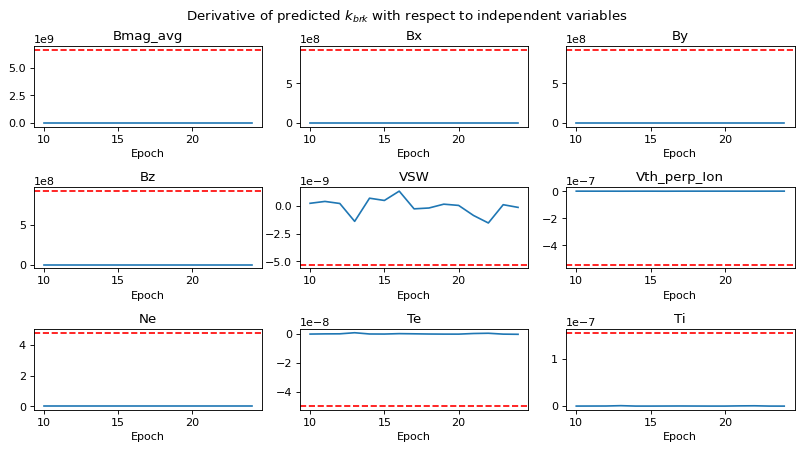

In [ ]:
indep_infl = ('Bmag_avg', 'Bx', 'By', 'Bz', 'VSW', 'Vth_perp_Ion', 
              'Ne', 'Te', 'Ti')
plt.subplots()
plt.suptitle('Derivative of predicted $k_{brk}$ with respect to' +
             ' independent variables')
for i, var in enumerate(indep_infl):
  col = indep_vars.index(var)
  plt.subplot(3, 3, i+1)
  x_axis = torch.arange(25)[10:]
  plt.plot(x_axis, m3['(16, 8, 4) drop 25%']['result'][2][10:, col])
  plt.axhline(grads[var].mean(), color='r', linestyle='--')
  plt.xlabel('Epoch')
  plt.title(var)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])

In [ ]:
deriv_vars[13], indep_vars[3]

('Lperp', 'Bmag_avg')

In [ ]:
m3_deriv['(16, 8, 4) drop 25%']['result'][2][:, 13], grads['Lperp']

(tensor([-5.2251e-02, -1.8995e-05,  1.8723e-06, -1.9888e-07,  1.1010e-07,
          3.1915e-09,  3.4892e-10, -1.5447e-09,  1.0056e-09,  2.5863e-09,
          3.7378e-10,  2.5515e-09,  1.0733e-09, -1.5728e-11,  1.0222e-09,
         -2.0783e-11, -2.4613e-10, -7.4423e-10,  8.4347e-10, -7.2358e-10,
         -3.5502e-11, -3.6145e-09,  1.7534e-09, -1.3694e-09,  1.4236e-09]),
 tensor([-50.0151, -49.1785, -47.2174,  ..., -42.5144, -42.5511, -43.4276],
        dtype=torch.float64))

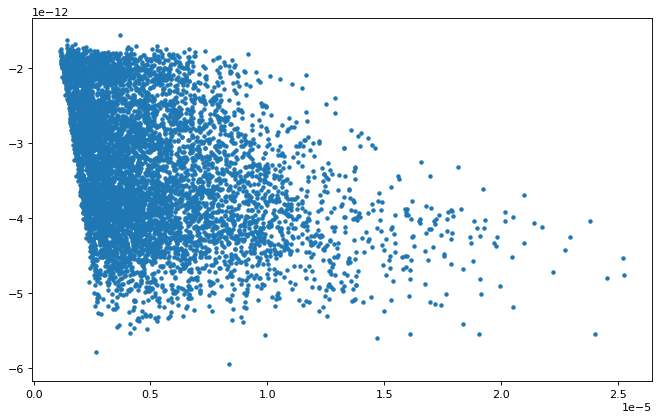

In [ ]:
deriv = dk_brk_dlambda_r(df['lambda_d']) * dlamda_r_dLperp(df['Lperp'],
                                                           df['d_e'], df['rho_s'])
plt.plot(df['k_brk'], deriv, '.')

# Appendix

Simple experiments with key functionality.

* https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
* https://pytorch.org/docs/stable/generated/torch.autograd.grad.html

In [36]:
i0 = torch.tensor([2., 4.], requires_grad=True)
i1 = torch.tensor([3., 5.], requires_grad=True)
z = 2.0*i0 + 3.0*i1 # dz_di0 = 2, dz_di1 = 3
y = z**2 # dy_dz = 2z

print('z:', z.detach(), '\ty:', y.detach())
print('dy/dz:', torch.autograd.grad(y, z, torch.ones(z.shape)))
print('dz/di0:', torch.autograd.grad(z, i0, torch.ones(i0.shape)))
print('dz/di1:', torch.autograd.grad(z, i1, torch.ones(i1.shape)))

z: tensor([13., 23.]) 	y: tensor([169., 529.])
dy/dz: (tensor([26., 46.]),)
dz/di0: (tensor([2., 2.]),)
dz/di1: (tensor([3., 3.]),)


PyTorch's `jacobian` function

* https://www.geeksforgeeks.org/jacobian-matrix-in-pytorch/

In [35]:
def f(x1, x2, x3):
  # Jacobian is [1, 1, 0], [x3, 0, x1], [0, 3*x2, 0]
  return torch.stack((x1 + x2, x3*x1, x2**3))

def f2(x1, x2, x3):
  return x1 + x2 + x3
 
# Defining input tensors
x1 = torch.tensor(3.0)
x2 = torch.tensor(4.0)
x3 = torch.tensor(5.0)
 
# Printing the Jacobian
print(torch.autograd.functional.jacobian(f, (x1, x2, x3)))
print(torch.autograd.functional.jacobian(f2, (x1, x2, x3)))

(tensor([1., 5., 0.]), tensor([ 1.,  0., 48.]), tensor([0., 3., 0.]))
(tensor(1.), tensor(1.), tensor(1.))


Test gradient methods with a simple neural network. Referenced Dive into Deep Learning:

* https://d2l.ai/chapter_linear-networks/linear-regression-concise.html
* https://d2l.ai/_modules/d2l/mxnet.html#synthetic_data

In [57]:
def synthetic_data(w, b, num_examples, stdev=0.1):
  '''Generate y = Xw + b + noise.'''
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X, w) + b
  y += torch.normal(0, stdev, y.shape)
  return X, torch.reshape(y, (-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True): 
  '''Construct a PyTorch data iterator.'''
  dataset = Data.TensorDataset(*data_arrays)
  return Data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [99]:
# Define model, loss function, & optimizer
net = nn.Sequential(nn.Linear(2, 1))
net.apply(init_parameters) # use previously defined function
loss_fun = nn.MSELoss()
opt = torch.optim.SGD(net.parameters(), lr=0.005)

# Train
num_epochs = 3
for epoch in range(num_epochs):
  for X, y in data_iter:
    # Forward
    X.requires_grad = True
    yhat = net(X)
    loss = loss_fun(yhat, y)

    # Backprop
    opt.zero_grad()
    loss.backward(retain_graph=True)
    dyhat_dX, = torch.autograd.grad(yhat, X, torch.ones(yhat.shape))
    print(dyhat_dX)
    opt.step()
  loss = loss_fun(net(features), labels)
  print(f'epoch {epoch}, loss {loss:f}')

tensor([[ 1.5020, -0.5577],
        [ 1.5020, -0.5577],
        [ 1.5020, -0.5577],
        [ 1.5020, -0.5577],
        [ 1.5020, -0.5577],
        [ 1.5020, -0.5577],
        [ 1.5020, -0.5577],
        [ 1.5020, -0.5577],
        [ 1.5020, -0.5577],
        [ 1.5020, -0.5577]])
tensor([[ 1.4913, -0.5865],
        [ 1.4913, -0.5865],
        [ 1.4913, -0.5865],
        [ 1.4913, -0.5865],
        [ 1.4913, -0.5865],
        [ 1.4913, -0.5865],
        [ 1.4913, -0.5865],
        [ 1.4913, -0.5865],
        [ 1.4913, -0.5865],
        [ 1.4913, -0.5865]])
tensor([[ 1.4852, -0.5880],
        [ 1.4852, -0.5880],
        [ 1.4852, -0.5880],
        [ 1.4852, -0.5880],
        [ 1.4852, -0.5880],
        [ 1.4852, -0.5880],
        [ 1.4852, -0.5880],
        [ 1.4852, -0.5880],
        [ 1.4852, -0.5880],
        [ 1.4852, -0.5880]])
tensor([[ 1.4856, -0.6211],
        [ 1.4856, -0.6211],
        [ 1.4856, -0.6211],
        [ 1.4856, -0.6211],
        [ 1.4856, -0.6211],
        [ 1.4856,

In [83]:
net[0].weight, X, X.shape, y.shape

(Parameter containing:
 tensor([[ 1.9779, -3.3886]], requires_grad=True), tensor([[ 0.0503,  1.0571],
         [ 2.3308, -1.2285],
         [ 0.2725, -1.0816],
         [-0.5888, -0.8198],
         [-0.2891, -1.7056],
         [ 0.1655,  1.2868],
         [ 0.4731, -0.2697],
         [ 0.2738,  0.8003],
         [-0.6569,  0.2356],
         [ 1.2764, -1.0169]]), torch.Size([10, 2]), torch.Size([10, 1]))

In [100]:
last_jacobian = torch.autograd.functional.jacobian(net, X)
last_jacobian.shape, last_jacobian[0][0][0][1]

(torch.Size([10, 1, 10, 2]), tensor(-3.2135))